In [1]:
from Training_Functions import make_train_set_for_target,mixed_curriculum_train
from Tomita_Grammars import *
from Extraction import extract

from transformers import Trainer, TrainingArguments
from transformers import BertConfig, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from tqdm import trange

import torch
import torch.nn as nn
import transformers
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, Dataset
from transformers import BertConfig, BertForSequenceClassification, DistilBertForSequenceClassification, DistilBertConfig, AdamW


In [38]:
alphabet = "01"
tokenize = ord
vocab_size = 128
distil_model_config = DistilBertConfig(
    vocab_size=vocab_size,   
    hidden_dim=32,
    dim=32,
    n_heads=4
    # note: not updated
)
train_arg = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=200,              
    per_device_train_batch_size=1,   
    per_device_eval_batch_size=1,    
    warmup_steps=500,                
    weight_decay=0.01,               
    logging_dir='./logs',            
    logging_steps=10,               
    learning_rate=5e-4,   
    logging_strategy='epoch',
    evaluation_strategy='epoch'
)
model_config = BertConfig(
    vocab_size=vocab_size, 
    hidden_size=32,  
    num_hidden_layers=2,  
    num_attention_heads=2,  
    intermediate_size=32,  
    num_labels=2,  
    pad_token_id=127 #anything unused !!
)

distil_model = DistilBertForSequenceClassification(distil_model_config)
model = BertForSequenceClassification(model_config)
target = tomita_4

/Users/pengqianhan/opt/anaconda3/envs/d2l/lib/python3.8/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [55]:
class NumberDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        string, label = self.data[idx]
        binary_list = [tokenize(bit) for bit in string]
        return {
            "input_ids": torch.tensor(binary_list, dtype=torch.long), 
            "labels": torch.tensor(label, dtype=torch.long)
        }
    
class HiddenStateDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        return x, y

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, rnn):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = rnn
        self.pre_classifier = nn.Linear(32, 32)
        self.classifier = nn.Linear(32, 2)
    def forward(self, x):
        x = self.embedding(x)
        _, x = self.rnn(x)
        x = self.pre_classifier(x)
        x = self.classifier(x)
        return x
    
class TransformerNetwork:
    def __init__(self, model, train_arg, vocab_size, alphabet, rnn_arg, target):
        """
        :param model: Transformer model
        :param train_arg: Training arguments for Transformer model
        :param alphabet: list of characters in the alphabet from 0 to 9. E.g. "01"
        :param rnn_arg: Arguments for RNN model, a dictionary
        :param target: Target language, a function
        """
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.rnn_train_data = None
        self.rnn_test_data = None
        self.target = target
        self.alphabet = alphabet
        self.model = model.to(self.device)
        self.train_arg = train_arg
        self.rnn_arg = rnn_arg
        # distil_model_config is ill implemented here
        rnn = nn.RNN(input_size=distil_model_config.dim, hidden_size=distil_model_config.dim, batch_first=True)
        self.rnn = RNNClassifier(vocab_size,distil_model_config.dim,rnn).to(self.device)
        self.data = list(make_train_set_for_target(self.target, alphabet).items())[1:]
        self.train_data, self.test_data = train_test_split(self.data, test_size=0.2, random_state=42)
        self.train_dataset = NumberDataset(self.train_data)
        self.test_dataset = NumberDataset(self.test_data)
        self.train_loader = DataLoader(self.train_dataset, batch_size=1, shuffle=True)
        self.test_loader = DataLoader(self.test_dataset, batch_size=1, shuffle=False)
        
    def classify_word(self, word):
        """
        :param word: a string of 0s and 1s
        :return: 1 if the word is in the target language, 0 otherwise
        """
        if len(word) == 0:
            return self.classify_state(torch.tensor([0 for _ in range(model_config.hidden_size)], dtype=torch.float32)).item()
        input = torch.tensor([tokenize(bit) for bit in word], dtype=torch.long).to(self.device)
        # print('input.shape for classify_word',input.shape)
        input = input.unsqueeze(0)#### change here
        with torch.no_grad():
            return self.rnn(input).argmax().item()
    def model_classify_word(self, word):
        """
        :param word: a string of 0s and 1s
        :return: 1 if the word is in the target language, 0 otherwise
        """
        if len(word) == 0:
            return self.target('')
        input = torch.tensor([tokenize(bit) for bit in word], dtype=torch.long).to(self.device).unsqueeze(0)
        with torch.no_grad():
            return self.model(input).logits.argmax().item()
    def train_transformer(self):
        """
        Train the transformer model
        """
        self.trainer = Trainer(
            model=self.model,
            args=self.train_arg,
            train_dataset=self.train_dataset,
            eval_dataset=self.test_dataset,
        )
        self.trainer.train()
        self.model.eval()
        correct = 0
        total = 0
        test_loader = DataLoader(self.test_dataset, batch_size=1, shuffle=False)
        for x in test_loader:
            input = x['input_ids'].to(self.device)
            label = x['labels']
            correct += self.model(input).logits.argmax() == label[0]
            total += 1
        print("Correct:" ,correct.item())
        print("Total:", total)
        self.trainer.evaluate()
    def train_rnn(self):
        """
        Train the RNN model, embedding is given by extract_embedding
        """
        # First load linear model from transformer
        def init_identity(m):
            if isinstance(m, nn.Linear):
                nn.init.eye_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
        # Initialize classifier in RNN
        assert (hasattr(transformer.model,'classifier')), 'Transformer has no classifier layer'
        self.rnn.classifier.load_state_dict(self.model.classifier.state_dict())
        if hasattr(transformer.model,'pre_classifier'):
            self.rnn.pre_classifier.load_state_dict(self.model.pre_classifier.state_dict())
        else:
            self.rnn.pre_classifier.apply(init_identity)
               
        # Make the training data
        self.rnn_train_data = []
        with torch.no_grad():
            for x in self.train_loader:
                input = x['input_ids'].to(self.device).squeeze(0)
                label = self.model(input.unsqueeze(0)).logits.argmax()
                self.rnn_train_data.append((input, label))
        self.rnn_train_data, self.rnn_test_data = train_test_split(self.rnn_train_data, test_size=0.2, random_state=42)
        rnn_train_dataset = HiddenStateDataset(self.rnn_train_data)
        rnn_test_dataset = HiddenStateDataset(self.rnn_test_data)
        rnn_train_loader = DataLoader(rnn_train_dataset, batch_size=1, shuffle=True)
        rnn_test_loader = DataLoader(rnn_test_dataset, batch_size=1, shuffle=False)
        # Train the self.rnn model
        self.rnn = self.rnn.to(self.device)
        optimizer = AdamW([{'params': self.rnn.embedding.parameters()},
                          {'params': self.rnn.rnn.parameters()}]
                          , lr=1e-3)
        for epoch in trange(200):
            for x in rnn_train_loader:
                input, label = x
                # print('input.shape for self.rnn',input.shape)##(1, 11), (1, 13)...
                output = self.rnn(input)
                output = output.squeeze(0)
                loss = nn.CrossEntropyLoss()(output, label)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
            for x in self.train_loader:
                # todo: add support for other bert
                bert_output = self.model.bert(x['input_ids'].to(transformer.device)).pooler_output
                # input = x['input_ids'].to(self.device).squeeze(0)
                input = x['input_ids'].to(self.device)
                # print('input.shape for self.rnn.embedding',input.shape)
                input = self.rnn.embedding(input)
                # print('input.shape for self.rnn.rnn',input.shape)
                output = self.rnn.rnn(input)[1]
                output.reshape(bert_output.shape)
                loss_func = nn.L1Loss(reduction = 'mean')
                loss = loss_func(bert_output,output)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
        # Test the self.rnn model
        self.rnn.eval()
        correct = 0
        total = 0
        for x in rnn_test_loader:
            input, label = x
            output = self.rnn(input)
            correct += output.argmax() == label
            total += 1
        print("Correct:" ,correct.item())
        print("Total:", total)
    def classify_state(self,state):
        output = self.rnn.pre_classifier(state.to(self.device))
        output = self.rnn.classifier(output)
        # return the label
        return output.argmax()
    def get_first_RState(self):
        state = [0 for _ in range(model_config.hidden_size)]
        #print("0",state, self.classify_state(torch.tensor(state, dtype=torch.float32)))
        return state, self.target('') #self.classify_state(torch.tensor(state, dtype=torch.float32)).item()
    def get_next_RState(self, state, char):
        input = self.rnn.embedding.state_dict()['weight'][tokenize(char)]
        input = input.unsqueeze(0).unsqueeze(0)
        input = input.to(self.device)
        state = torch.tensor(state, dtype=torch.float32).view(1, 1, 32)
        state = state.to(self.device)
        output, next_state = self.rnn.rnn(input, state)
        return next_state.squeeze().tolist(), self.classify_state(next_state.squeeze()).item()

In [ ]:
model = BertForSequenceClassification(model_config).from_pretrained('./results/checkpoint-550000')
transformer = TransformerNetwork(model, train_arg, vocab_size, alphabet, model_config, target)
#transformer.train_transformer()
transformer.model.eval()

In [56]:
transformer = TransformerNetwork(model, train_arg, vocab_size, alphabet, model_config, target)
# transformer.train_transformer()
transformer.model.eval()

made train set of size: 3341 , of which positive examples: 1705


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(128, 32, padding_idx=127)
      (position_embeddings): Embedding(512, 32)
      (token_type_embeddings): Embedding(2, 32)
      (LayerNorm): LayerNorm((32,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=32, out_features=32, bias=True)
              (key): Linear(in_features=32, out_features=32, bias=True)
              (value): Linear(in_features=32, out_features=32, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=32, out_features=32, bias=True)
              (LayerNorm): LayerNorm((32,), eps=1e-12, elementwise_affine=T

In [30]:
transformer = TransformerNetwork(model, train_arg, vocab_size, alphabet, model_config, target)
transformer.model.eval()
transformer.rnn.train()
transformer.train_rnn()

made train set of size: 3329 , of which positive examples: 1704


  0%|          | 0/200 [00:00<?, ?it/s]/Users/pengqianhan/opt/anaconda3/envs/d2l/lib/python3.8/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1, 1, 32])) that is different to the input size (torch.Size([1, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
100%|██████████| 200/200 [58:46<00:00, 17.63s/it]


Correct: 528
Total: 533


In [57]:
data = make_train_set_for_target(target,alphabet)
all_words = sorted(list(data.keys()),key=lambda x:len(x))
print('all_words:',all_words)
pos = next((w for w in all_words if transformer.classify_word(w)==True),None)
neg = next((w for w in all_words if transformer.classify_word(w)==False),None)
starting_examples = [w for w in [pos,neg] if not None == w] + all_words[:10] # else bad
print(starting_examples)

made train set of size: 3365 , of which positive examples: 1714
all_words: ['', '1', '0', '00', '01', '11', '10', '011', '110', '100', '111', '001', '101', '010', '000', '0100', '0011', '1101', '1100', '0110', '0010', '1111', '1011', '0111', '0101', '1001', '1010', '1110', '0001', '1000', '0000', '01010', '00110', '11010', '01101', '10010', '11001', '00100', '11101', '10100', '01001', '00101', '01111', '11100', '01100', '11111', '10111', '10110', '00111', '11110', '01110', '10011', '10101', '11011', '01011', '00001', '00000', '10001', '00011', '10000', '11000', '01000', '00010', '001011', '111110', '111100', '110010', '110100', '001001', '001100', '001010', '001110', '101101', '110110', '111010', '011010', '010100', '101110', '010111', '011011', '110111', '011110', '101100', '111111', '100110', '111011', '110011', '001111', '101001', '100111', '011100', '101010', '011001', '100101', '111001', '111101', '010110', '010010', '001101', '100100', '110101', '011111', '101111', '101000', '110

In [58]:
transformer.rnn.eval()
dfa = extract(transformer,time_limit = 50,initial_split_depth = 10,starting_examples=all_words)

provided counterexamples are: ['', '1', '0', '00', '01', '11', '10', '011', '110', '100', '111', '001', '101', '010', '000', '0100', '0011', '1101', '1100', '0110', '0010', '1111', '1011', '0111', '0101', '1001', '1010', '1110', '0001', '1000', '0000', '01010', '00110', '11010', '01101', '10010', '11001', '00100', '11101', '10100', '01001', '00101', '01111', '11100', '01100', '11111', '10111', '10110', '00111', '11110', '01110', '10011', '10101', '11011', '01011', '00001', '00000', '10001', '00011', '10000', '11000', '01000', '00010', '001011', '111110', '111100', '110010', '110100', '001001', '001100', '001010', '001110', '101101', '110110', '111010', '011010', '010100', '101110', '010111', '011011', '110111', '011110', '101100', '111111', '100110', '111011', '110011', '001111', '101001', '100111', '011100', '101010', '011001', '100101', '111001', '111101', '010110', '010010', '001101', '100100', '110101', '011111', '101111', '101000', '110000', '000110', '100000', '001000', '000100',

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

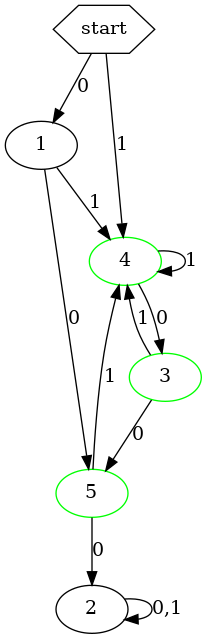

testing on train set, i.e. test set is train set
test set size: 3370
of which positive: 1724 (51.15%)
rnn score against target: 3368 (99.94%)
model score against target: 3343 (99.19%)
rnn score against model: 3341 (99.13%)
extracted dfa score against rnn: 3370 (100.0%)
extracted dfa score against model: 3341 (99.13%)
extracted dfa score on test set: 3368 (99.94%)


In [11]:
from math import pow
def percent(num,digits=2):
    tens = pow(10,digits)
    return str(int(100*num*tens)/tens)+"%"

dfa.draw_nicely(maximum=30) #max size willing to draw

test_set = data
print("testing on train set, i.e. test set is train set")
# we're printing stats on the train set for now, but you can define other test sets by using
# make_train_set_for_target

n = len(test_set)
print("test set size:", n)
pos = len([w for w in test_set if target(w)])
print("of which positive:",pos,"("+percent(pos/n)+")")

rnn_target = len([w for w in test_set if transformer.classify_word(w)==target(w)])
print("rnn score against target:",rnn_target,"("+percent(rnn_target/n)+")")

model_target = len([w for w in test_set if transformer.model_classify_word(w)==target(w)])
print("model score against target:",model_target,"("+percent(model_target/n)+")")

model_rnn = len([w for w in test_set if transformer.model_classify_word(w)==transformer.classify_word(w)])
print("rnn score against model:",model_rnn,"("+percent(model_rnn/n)+")")

dfa_rnn = len([w for w in test_set if transformer.classify_word(w)==dfa.classify_word(w)])
print("extracted dfa score against rnn:",dfa_rnn,"("+percent(dfa_rnn/n)+")")

dfa_target_model = len([w for w in test_set if dfa.classify_word(w)==transformer.model_classify_word(w)])
print("extracted dfa score against model:",dfa_target_model,"("+percent(dfa_target_model/n)+")")

dfa_target = len([w for w in test_set if dfa.classify_word(w)==target(w)])
print("extracted dfa score on test set:",dfa_target,"("+percent(dfa_target/n)+")")
